# Notebook to test detection model 

In [1]:
import os
import torch
import torch.backends.cudnn as cudnn
import numpy as np
from data import cfg_mnet, cfg_re50
from layers.functions.prior_box import PriorBox
from utils.nms.py_cpu_nms import py_cpu_nms
import cv2
from models.retinaface import RetinaFace
from utils.box_utils import decode, decode_landm

In [10]:
from pathlib import Path

In [2]:
# from fastai.vision import *

In [3]:
def check_keys(model, pretrained_state_dict):
    ckpt_keys = set(pretrained_state_dict.keys())
    model_keys = set(model.state_dict().keys())
    used_pretrained_keys = model_keys & ckpt_keys
    unused_pretrained_keys = ckpt_keys - model_keys
    missing_keys = model_keys - ckpt_keys
    print('Missing keys:{}'.format(len(missing_keys)))
    print('Unused checkpoint keys:{}'.format(len(unused_pretrained_keys)))
    print('Used keys:{}'.format(len(used_pretrained_keys)))
    assert len(used_pretrained_keys) > 0, 'load NONE from pretrained checkpoint'
    return True

In [4]:
def remove_prefix(state_dict, prefix):
    ''' Old style model is stored with all names of parameters sharing common prefix 'module.' '''
    print('remove prefix \'{}\''.format(prefix))
    f = lambda x: x.split(prefix, 1)[-1] if x.startswith(prefix) else x
    return {f(key): value for key, value in state_dict.items()}

In [5]:
def load_model(model, pretrained_path, load_to_cpu):
    print('Loading pretrained model from {}'.format(pretrained_path))
    if load_to_cpu:
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage)
    else:
        device = torch.cuda.current_device()
        pretrained_dict = torch.load(pretrained_path, map_location=lambda storage, loc: storage.cuda(device))
    if "state_dict" in pretrained_dict.keys():
        pretrained_dict = remove_prefix(pretrained_dict['state_dict'], 'module.')
    else:
        pretrained_dict = remove_prefix(pretrained_dict, 'module.')
    check_keys(model, pretrained_dict)
    model.load_state_dict(pretrained_dict, strict=False)
    return model

In [6]:
cfg = cfg_mnet
cpu = False
origin_size = True
confidence_threshold = 0.02
nms_threshold = 0.4
save_folder = "saved_images/"
save_image = True
vis_thres = 0.5

In [8]:
net = RetinaFace(cfg=cfg, phase = 'test')
net = load_model(net, './weights/mobilenet0.25_Final.pth', cpu)
net.eval()
print('Finished loading model!')
# print(net)
cudnn.benchmark = True
device = torch.device("cpu" if cpu else "cuda")
net = net.to(device)

Loading pretrained model from ./weights/mobilenet0.25_Final.pth
remove prefix 'module.'
Missing keys:0
Unused checkpoint keys:0
Used keys:300
Finished loading model!


In [11]:
image_path = Path("D:/Datasets/COVID-19-mask-detection/training/images/test_00000199.jpg")
img_raw = cv2.imread(str(image_path), cv2.IMREAD_COLOR)
img = np.float32(img_raw)

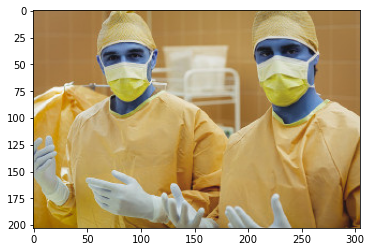

In [12]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(img_raw)

In [14]:
#  # testing scale
# target_size = 1600
# max_size = 2150
# im_shape = img.shape
# im_size_min = np.min(im_shape[0:2])
# im_size_max = np.max(im_shape[0:2])
# resize = float(target_size) / float(im_size_min)
# # prevent bigger axis from being more than max_size:
# if np.round(resize * im_size_max) > max_size:
#     resize = float(max_size) / float(im_size_max)
if origin_size:
    resize = 1

In [15]:
if resize != 1:
    img = cv2.resize(img, None, None, fx=resize, fy=resize, interpolation=cv2.INTER_LINEAR)
im_height, im_width, _ = img.shape
scale = torch.Tensor([img.shape[1], img.shape[0], img.shape[1], img.shape[0]])
img -= (104, 117, 123)
img = img.transpose(2, 0, 1)
img = torch.from_numpy(img).unsqueeze(0)
img = img.to(device)
scale = scale.to(device)

In [16]:
%time loc, conf, _ = net(img)  # forward pass

Wall time: 1.13 s


In [17]:
priorbox = PriorBox(cfg, image_size=(im_height, im_width))
priors = priorbox.forward()
priors = priors.to(device)
prior_data = priors.data
boxes = decode(loc.data.squeeze(0), prior_data, cfg['variance'])
boxes = boxes * scale / resize
boxes = boxes.cpu().numpy()
scores = conf.squeeze(0).data.cpu().numpy()[:, 1]

In [18]:
# ignore low scores
inds = np.where(scores > confidence_threshold)[0]
boxes = boxes[inds]
# landms = landms[inds]
scores = scores[inds]

In [19]:
# keep top-K before NMS
order = scores.argsort()[::-1]
# order = scores.argsort()[::-1][:args.top_k]
boxes = boxes[order]
# landms = landms[order]
scores = scores[order]

In [20]:
# do NMS
dets = np.hstack((boxes, scores[:, np.newaxis])).astype(np.float32, copy=False)
keep = py_cpu_nms(dets, nms_threshold)
# keep = nms(dets, args.nms_threshold,force_cpu=args.cpu)
dets = dets[keep, :]
# landms = landms[keep]

In [21]:
# dets = np.concatenate((dets, landms), axis=1)

In [22]:
# img_name = "test_00000199.jpg"
# save_name = save_folder + img_name[:-4] + ".txt"
# dirname = os.path.dirname(save_name)
# if not os.path.isdir(dirname):
#     os.makedirs(dirname)
# with open(save_name, "w") as fd:
#     bboxs = dets
#     file_name = os.path.basename(save_name)[:-4] + "\n"
#     bboxs_num = str(len(bboxs)) + "\n"
#     fd.write(file_name)
#     fd.write(bboxs_num)
#     for box in bboxs:
#         x = int(box[0])
#         y = int(box[1])
#         w = int(box[2]) - int(box[0])
#         h = int(box[3]) - int(box[1])
#         confidence = str(box[4])
#         line = str(x) + " " + str(y) + " " + str(w) + " " + str(h) + " " + confidence + " \n"
#         fd.write(line)

In [38]:
# # save image
# save_image = True
# if save_image:
#     for b in dets:
#         if b[4] < vis_thres:
#             continue
#         text = "{:.4f}".format(b[4])
#         b = list(map(int, b))
#         cv2.rectangle(img_raw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 2)
# #         cx = b[0]
# #         cy = b[1] + 12
# #         cv2.putText(img_raw, text, (cx, cy),
# #                     cv2.FONT_HERSHEY_DUPLEX, 0.5, (255, 255, 255))

# #         # landms
# #         cv2.circle(img_raw, (b[5], b[6]), 1, (0, 0, 255), 4)
# #         cv2.circle(img_raw, (b[7], b[8]), 1, (0, 255, 255), 4)
# #         cv2.circle(img_raw, (b[9], b[10]), 1, (255, 0, 255), 4)
# #         cv2.circle(img_raw, (b[11], b[12]), 1, (0, 255, 0), 4)
# #         cv2.circle(img_raw, (b[13], b[14]), 1, (255, 0, 0), 4)
#     # save image
#     if not os.path.exists("./results/"):
#         os.makedirs("./results/")
#     name = "./results/" + str(3) + ".jpg"
#     cv2.imwrite(name, img_raw)

In [23]:
good_dets = []
for b in dets:
    if b[4] < vis_thres:
        continue
    good_dets.append(b)

In [25]:
good_dets

[array([206.02126  ,  17.263517 , 259.68323  ,  84.47562  ,   0.9980855],
       dtype=float32),
 array([ 63.554306 ,  19.682766 , 109.26897  ,  80.75824  ,   0.9920101],
       dtype=float32)]